# An Algorithm for a Dog Identification App Us CNNs

---

### Introduction

In this notebook, I will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, I will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.

### The Road Ahead

I broke the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Importing Datasets
* [Step 1](#step1): Detecting Humans
* [Step 2](#step2): Detecting Dogs
* [Step 3](#step3): Creating a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Creating a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Implementing the Mobile App Algorithm
* [Step 6](#step6): Testing the Algorithm

---
<a id='step0'></a>
## Step 0: Importing Datasets

Make sure that you've downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, I saved the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detecting Humans

In this section, I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


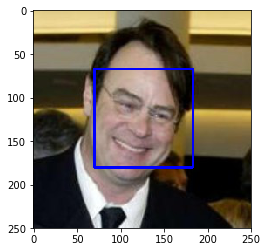

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### A Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector


In [4]:
from tqdm import tqdm

# get the first 100 images in guman and dog files 
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

def percentage_detected(images,model):
    ''' returns the percentage of identifiable classifications in group of images dependng on a prediction of a model.
    
        Args:
            images: a numpy array containing the images paths.
            model: a function that returns true or false depending on the ooutput of the model.
            
        returns:
            Percentage of object detection from the specified model (float)
    
    '''
    count=0
    for image in tqdm(images,"Progress"):
        if model(image):
            count+=1
    return (count/len(images))*100

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that this algorithm falls short of this goal, but still gives acceptable performance. in the code cell below, I extracted the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short` and implemented a function that calculates the precentage of detection.

__Answer:__ 


In [5]:
# calculate percentage of humans identified in human_files_short images
humans_in_human_files_short=percentage_detected(human_files_short,face_detector)

# calculate percentage of dogs identified as humans in dogs_files_short images
humans_in_dog_files_short=percentage_detected(dog_files_short,face_detector)

print("Results from the cascade classifier:")

print("The percentage of detected human faces from the first 100 images in human_files: {}%"
      .format(humans_in_human_files_short))

print("The percentage of detected human faces from the first 100 images in dog_files: {}%"
      .format(humans_in_dog_files_short))

Progress: 100%|██████████| 100/100 [00:29<00:00,  7.33it/s]

Results from the cascade classifier:
The percentage of detected human faces from the first 100 images in human_files: 98.0%
The percentage of detected human faces from the first 100 images in dog_files: 17.0%


These are arguably good results, but we can get much better accuracy using a different approach.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I used a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtaining Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

# view the model archeticture
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, I will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image,ImageFile

# since some images are truncated PIL will throw an error while loading them.
# the next line will make it load the image nevertheless
ImageFile.LOAD_TRUNCATED_IMAGES = True 

import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    # open the image
    image = Image.open(img_path)
    
    # preprocessing steps
    transform = transforms.Compose([transforms.Resize(250),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456,0.406],
                                                         [0.229,0.224,0.225])])
    
    # preprocess then convert the image into a 4-dimensional tensor 
    image = transform(image).unsqueeze_(0) 
    
    # move tensor to GPU if available
    if use_cuda:
        image = image.cuda()
    
    # set the model to evaluation mode to disable dropout
    VGG16.eval()
    
    # turn off gradients then predict the probabilities for each class from VGG16 model
    with torch.no_grad():
        probabilities = VGG16(image)
        
    # get the class index with the highest probability as the prediction
    predicted_class_index = torch.argmax(probabilities).item()    
    
    # set the model to traning mode
    VGG16.train()
    
    # return the prediction of the model
    return predicted_class_index 

### A Dog Detector Function

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, I need only to check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [8]:
# returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    # use the VGG16_predict function to detect dogs in the image
    prediction = VGG16_predict(img_path)
    
    #  returns true in case of a dog is detected else returns false 
    return 151 <= prediction <= 268 

### Assessing the Dog Detector

- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [9]:
# I will use the percentage_detected function to calculate the percentage of humans detected on both group of images

# calculate percentage of humans identified in human_files_short images
dogs_in_human_files_short = percentage_detected(human_files_short,dog_detector)

# calculate percentage of dogs identified as humans in dogs_files_short images
dogs_in_dog_files_short = percentage_detected(dog_files_short,dog_detector)

print("Results from the vgg16 classifier:")

print("The percentage of detected dogs from the first 100 images in human_files using vgg16: {}%"
      .format(dogs_in_human_files_short))

print("The percentage of detected dogs from the first 100 images in dog_files using vgg16: {}%"
      .format(dogs_in_dog_files_short))

Progress: 100%|██████████| 100/100 [00:04<00:00, 25.73it/s]

Results from the vgg16 classifier:
The percentage of detected dogs from the first 100 images in human_files using vgg16: 0.0%
The percentage of detected dogs from the first 100 images in dog_files using vgg16: 100.0%


We can see that the vgg16 model provides much better results than the cascade classificer from openCV. it deten't detect any dogs in human faces images, and detected all dogs in the dog files.

---
<a id='step3'></a>
## Step 3: Creating a CNN to Classify Dog Breeds (from Scratch)

Now that I have functions for detecting humans and dogs in images, I need a way to predict breed from images.  In this step, I will create a CNN that classifies dog breeds.  

I mentioned that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

I also want to mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specifying Data Loaders for the Dog Dataset

in the code cell below, I created three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively). 

In [10]:
import os
from torchvision import datasets

images_directory="/data/dog_images/"

# specifiy batch size
batch_size=25

# transformations for training images
train_transforms = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(45),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])])

# transformations for validation and testing images
valid_test_transforms = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])])

# preprocess and load images
train_data = datasets.ImageFolder(images_directory+'train', transform=train_transforms)
valid_data = datasets.ImageFolder(images_directory+'valid', transform=valid_test_transforms)
test_data = datasets.ImageFolder(images_directory+'test', transform=valid_test_transforms)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

# define a dictionary with the previous loaders
loaders_scratch = {'train': train_loader,'valid': valid_loader,'test': test_loader}

- For the training images, I scaled the the images to make them 256x256 and then cropped them in the center by 224x224 I choose this number to be relatively small to make the training faster, as larger images will take longer to train on. then I applied some data augmentation transforms, then converted the images to tensors, finally I normalized all images. 
- I used mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] because these values were computed using the images of ImageNet dataset. That's why it's considered as one of the good practices to use this combination of mean and std dev while working with RGB images.

- for validation and test images, I did the same process except I didn't add data augmentation to the preprocessing.

- I decided to go with augmenting the data, because trainng CNNs relies heavily on the amount of data we have, by data augmentation we are adding more data for the model to train on. this will help the model generalize better.


### Model Architecture

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ### convolutional layers ###
        
        # convolutional layer (sees 224x224x3 tensor)
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        # convolutional layer (sees 28x28x64 tensor)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        
        ## max pooling layer
        self.pool=nn.MaxPool2d(2,2)
    
        ### linear layers ###
        
        # linear layer (14*14*128 --> 2048)
        self.fc1 = nn.Linear(14*14*128,2048)
        
        # linear layer (2048 --> 512)
        self.fc2 = nn.Linear(2048,512)
        
        # linear layer (512 --> 133)
        self.fc3 = nn.Linear(512,133)
            
        ## dropout layer
        self.dropout=nn.Dropout(p = 0.35)

    def forward(self, x):
        ## Define forward behavior
        # pass through convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # flatten image input for linear layers
        x = x.view(-1, 14*14*128)
        
        # dropout layer
        x = self.dropout(x)
        
        # pass through linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch = model_scratch.cuda()

I structured 4 convolutional layers to detect complex patterns in images without overfitting, each convolutional layer is followed by a maxpooling layer which keeps only the most active pixels from the previous layers, thus reduces the size of the input for the following layer ,then I added 3 linear layers each having dropout probability for its units that's equal to 1/4 to avoid overfitting. I choosed ReLU as the activation function of the linear layers becaus it does not activate all the neurons at the same time which will make the network train much faster. 

### Specifiying Loss Function and Optimizer

In [12]:
import torch.optim as optim

### define the loss function
criterion_scratch = nn.CrossEntropyLoss()

# define the optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.05)

### Training and Validating the Model

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU if available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # feed forward through network and calculating output
            output = model(data)
            
            # calculate loss for the output
            loss = criterion(output,target)
            
            # backbropagation through the network to calculate the gradient of the loss with respect to the model parameters 
            loss.backward()
            
            # perform a single optimizer step to update weights
            optimizer.step()
            
            # update the average training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            
        ######################    
        # validate the model #
        ######################
        
        # deactivationg off gradients which saves memory and computations
        with torch.no_grad():
            
            # set model to evaluation mode to disable dropout layers for evaluation
            model.eval()
            
            for batch_idx, (data, target) in enumerate(loaders['valid']):
            
            # move to GPU if available
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                
                # feed forward through network and calculate output
                output = model(data)
                
                # calculate loss for the output
                loss = criterion(output,target)
                
                # update the average validation loss 
                valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            
            # print the decrease in validation loss with the new model we just trained in the previous loop
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            # save the new model
            torch.save(model.state_dict(),save_path)
            
            # update the minimum loss to the least loss so far
            valid_loss_min = valid_loss
    
    # return trained model
    return model

In [14]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.887987 	Validation Loss: 4.884078
Validation loss decreased (inf --> 4.884078).  Saving model ...
Epoch: 2 	Training Loss: 4.879014 	Validation Loss: 4.876194
Validation loss decreased (4.884078 --> 4.876194).  Saving model ...
Epoch: 3 	Training Loss: 4.871289 	Validation Loss: 4.872216
Validation loss decreased (4.876194 --> 4.872216).  Saving model ...
Epoch: 4 	Training Loss: 4.847289 	Validation Loss: 4.816607
Validation loss decreased (4.872216 --> 4.816607).  Saving model ...
Epoch: 5 	Training Loss: 4.712941 	Validation Loss: 4.969159
Epoch: 6 	Training Loss: 4.630192 	Validation Loss: 4.661789
Validation loss decreased (4.816607 --> 4.661789).  Saving model ...
Epoch: 7 	Training Loss: 4.569645 	Validation Loss: 4.593698
Validation loss decreased (4.661789 --> 4.593698).  Saving model ...
Epoch: 8 	Training Loss: 4.493647 	Validation Loss: 4.613371
Epoch: 9 	Training Loss: 4.392147 	Validation Loss: 4.507610
Validation loss decreased (4.593698 --> 4.

The model started overfitting from around epoch 45 since the training loss is much smaller than the validation loss, I think this is due to the large number of classes and small number of layers, we also need much more data for such a very difficult classification.

In [15]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# move model to GPU if available
if use_cuda:
    model_scratch=model_scratch.cuda()

### Testing the Model

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        # move to GPU if available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return pred

In [17]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.599713


Test Accuracy: 20% (171/836)


The accuracy of this model is very low and that's expected.

---
<a id='step4'></a>
## Step 4: Creating a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.

### Specifying Data Loaders for the Dog Dataset

In [18]:
# specifiyng the same previous data loaders for the new model
loaders_transfer = loaders_scratch

### Model Architecture


In [19]:
# load the pretrained model from Pytorch
model_transfer= models.vgg16(pretrained=True)

# deactivate training for all feature layers 
for param in model_transfer.features.parameters():
    param.requires_grad=False 

# update the classifier layers to contain only 133 classes (dogs breeds)
model_transfer.classifier = nn.Sequential(nn.Linear(25088, 4096),
                           nn.ReLU(),
                           nn.Dropout(0.25),
                           nn.Linear(4096, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.25),
                           nn.Linear(1024, 133))

# move to GPU if available
if use_cuda:
    model_transfer = model_transfer.cuda()

- I turned off gradient calculations for the features layers of the model since these work as a very good feature detectors so the weights won't be updated in the training process.
- I replaced the classifier layers to containn the desired number of classes at the output (133 classes) for dog breeds, through this layers, I tried to minimize the number of units gradually from 25088 which is the output of the last convolutional layer to 133 classes.

### Specifying Loss Function and Optimizer

In [20]:
# the loss function for the transfer learning model
criterion_transfer = nn.CrossEntropyLoss()

# the optimizer of the transfer learning model
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(),lr=0.01)

### Training and Validating the Model

In [21]:
# train the model
model_transfer = train(30, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.974013 	Validation Loss: 2.823257
Validation loss decreased (inf --> 2.823257).  Saving model ...
Epoch: 2 	Training Loss: 2.179071 	Validation Loss: 1.787177
Validation loss decreased (2.823257 --> 1.787177).  Saving model ...
Epoch: 3 	Training Loss: 1.545639 	Validation Loss: 1.372032
Validation loss decreased (1.787177 --> 1.372032).  Saving model ...
Epoch: 4 	Training Loss: 1.254863 	Validation Loss: 0.910808
Validation loss decreased (1.372032 --> 0.910808).  Saving model ...
Epoch: 5 	Training Loss: 1.097958 	Validation Loss: 1.235054
Epoch: 6 	Training Loss: 0.958636 	Validation Loss: 0.902443
Validation loss decreased (0.910808 --> 0.902443).  Saving model ...
Epoch: 7 	Training Loss: 0.857194 	Validation Loss: 0.780890
Validation loss decreased (0.902443 --> 0.780890).  Saving model ...
Epoch: 8 	Training Loss: 0.780400 	Validation Loss: 0.973712
Epoch: 9 	Training Loss: 0.720603 	Validation Loss: 0.846870
Epoch: 10 	Training Loss: 0.662864 	Valida

In [22]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# move model to GPU if available
if use_cuda:
    model_transfer=model_transfer.cuda()

### Testing the Model

In [23]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda);

Test Loss: 0.700102


Test Accuracy: 81% (680/836)


Now the accuracy is much better.

### Predicting Dog Breed with the Model

in the code cell celow, I implemented a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [24]:
def predict_breed_transfer(img_path):
    '''load the image and return the predicted breed'''
    # open the image
    image = Image.open(img_path)
    
    # preprocess the image and add another dimension to the output tensor
    image = valid_test_transforms(image).unsqueeze(0)
    
    # move image to GPU if available
    if use_cuda:
        image=image.cuda()
        
    # set the model to evaluation mode
    model_transfer.eval()
        
    # get the prediction from the model_transfer through the model test
    prediction =  model_transfer(image)
    
    # get the ndex of the class with the highest probability in the prediction
    class_index = torch.argmax(prediction).item()
    
    # list of class names by index, i.e. a name can be accessed like class_names[0]
    class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

    
    # get the name of the breed that's related to the predicted index
    pred_dog_breed = class_names[class_index]
    
    return pred_dog_breed

---
<a id='step5'></a>
## Step 5: Implementing the Mobile App Algorithm

An algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [25]:
def run_app(img_path):
    ''' prints:
            If a dog is detected in the image, return the predicted breed.
            If a human is detected in the image, return the resembling dog breed.
            If neither is detected in the image, provide output that indicates an error.
    '''
    # use the transfer learning model to predict the dog breed in image
    prediction = predict_breed_transfer(img_path)
    
    # open and print the image
    image = Image.open(img_path) 
    plt.imshow(image)
    plt.show()
    print("Detecting...")
    
    # check if a dog is detected in the image
    if dog_detector(img_path):
        
        # print the dog breed prediction
        print("Dog detected in the image, its breed is:" , prediction)
    
    # check if a human is detected in the image
    elif face_detector(img_path):
        
        # print the dog breed with the closest appearance to the human in image
        print("This is a human image, the closest dog breed in appearance is:", prediction)
        
    # if no dog or human is detected in the image    
    else:
        print("Error, no dog or human detected in the image.")
    print("_"*100)

---
<a id='step6'></a>
## Step 6: Testing the Algorithm

In this section, I will take my new algorithm for a spin. I used AI generated human faces images for testing.

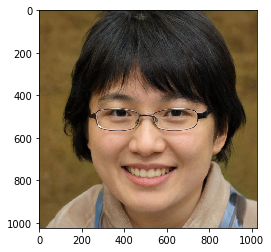

Detecting...
This is a human image, the closest dog breed in appearance is:  Bearded collie
_________________________


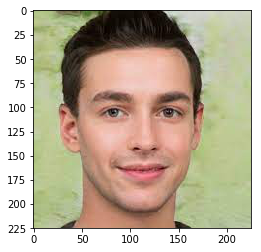

Detecting...
This is a human image, the closest dog breed in appearance is:  Dogue de bordeaux
_________________________


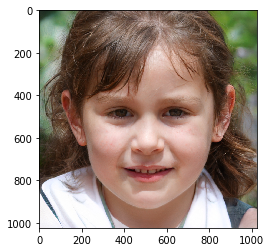

Detecting...
This is a human image, the closest dog breed in appearance is:  Bichon frise
_________________________


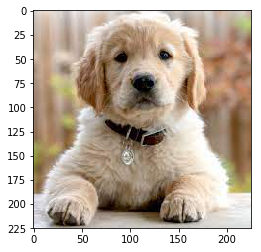

Detecting...
Dog detected in the image, its breed is:  Golden retriever
_________________________


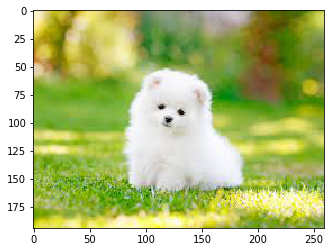

Detecting...
Dog detected in the image, its breed is:  Maltese
_________________________


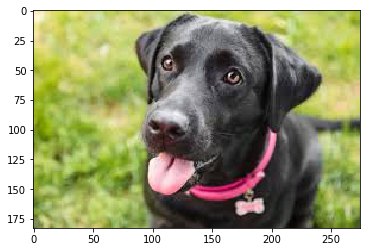

Detecting...
Dog detected in the image, its breed is:  German shorthaired pointer
_________________________


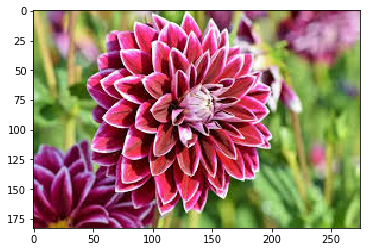

Detecting...
Error, no dog or human detected in the image.
_________________________


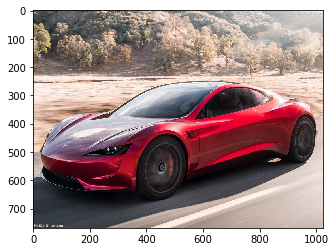

Detecting...
Error, no dog or human detected in the image.
_________________________


In [26]:
# test the algorithm
human_files = np.array(glob("my_images/humans/*"))
dog_files = np.array(glob("my_images/dogs/*"))
other_files = np.array(glob("my_images/other/*"))

for file in np.hstack((human_files, dog_files, other_files)):
    run_app(file)

#### To improve the algorithm we can:

- Stop training when the validation loss is larger than the training loss for a specified number of sequential epochs and with a specified difference., this will decrease unnecessary training time because the model will become more and more overfitted and fail to generalize.

- Automate the choice of the learning rate.

- Add more layers, this will definetly increase the model's accuracy as it will learn more complicated patterns and generalize better.

- Tracking the predictions to detect which images confuse the network more. we can try to solve this by gathering more data for them.

- Visualize the training and traning losses to get a better intuition about how and when the model starts overfitting.